In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(linewidth=100)
import os

In [2]:
from my_modules import compute

In [3]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import seaborn as sns

sns.set_style("whitegrid")

font = {'family': 'sans-serif', 'serif' : 'Helvetica',
        'size'   : 25}
plt.rc('font', **font)

In [4]:
# color map
# stab_cmap = sns.cubehelix_palette(n_colors=20, start=2.8, rot=0.1, gamma=1.0, hue=0.8, light=0.97, dark=0.3, reverse=True, as_cmap=True)
stab_cmap = sns.cubehelix_palette(n_colors=20, start=0, rot=0.2, gamma=1.0, hue=0.8, light=0.97, dark=0.3, reverse=True, as_cmap=True)
plasticity_cmap = 'RdGy'

In [5]:
storage = os.environ['MICOM_EXP'] + 'setA_coculture_b12_c96/' # on Peregrine
print(storage)

meta_species = pd.read_csv(storage + "selected_species_setA.tsv", sep="\t")
meta_species

/data/s4278836/First_project/experiments/setA_coculture_b12_c96/


Ecotype Ecotype_ID Species_ID                             Species_name
0       I        I_a    setA_15                Helicobacter_pylori_26695
1       I        I_b    setA_21           Pseudomonas_nitroreducens_HBP1
2      II       II_a    setA_11               Eggerthella_lenta_DSM_2243
3      II       II_b    setA_24         Ruminococcus_lactaris_ATCC_29176
4     III      III_a     setA_6         Brevibacillus_brevis_NBRC_100599
5     III      III_b    setA_13  Escherichia_coli_str_K_12_substr_MG1655
6      IV       IV_a    setA_19             Odoribacter_laneus_YIT_12061
7      IV       IV_b    setA_20           Peptoniphilus_timonensis_JC401
8       V        V_a    setA_16              Lactobacillus_gastricus_PS3

In [6]:
data_dir = storage + 'features/'
culture_type = 'continuous'
media=['EU_avg', 'high_fat']

# for computing interaction coefficients
mono_data_dir = os.environ['MICOM_EXP'] + 'setA_mono_b12_c144/features/' # on Peregrine

# for competitive exclusion assessment
min_density=1.0e-2

In [7]:
# for annotating species with their "degree of plasticity" in mono-culture
mono_plasticity_file = "../setA_mono_b12_c144/features/log_fold_change.plasticity.tsv"

mono_plasticity = pd.read_csv(mono_plasticity_file, sep='\t', usecols=['species_ID', 'media', 'log_fold_change', 'culture_type'])

# to extract list of species ID in the correct order
plastic_interactions, plastic_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=True, 
                                                                rm_compet_excl=True, min_survived=min_density,
                                                                intra=True, method='glv')

mono_plas = mono_plasticity.loc[(mono_plasticity['culture_type'] == culture_type) & (mono_plasticity['media'].isin(media)) &
                                (mono_plasticity['species_ID'].isin(plastic_meta['species_ID'])), :]

mono_plas = mono_plas.pivot(index='species_ID', columns='media', values='log_fold_change')
mono_plas = mono_plas.reindex(index=plastic_meta['species_ID'])
mono_plas = mono_plas.reindex(columns=media)

pmo_min = mono_plasticity['log_fold_change'].min() # min across all 18 species of set A & all 11 diets - to get negative value
print(pmo_min)
pmo_max = mono_plas.to_numpy().max()
print(pmo_max)

mono_plas

-0.009463740740957792
4.478131823042856


/data/s4278836/First_project/analysis/setA_coculture_b12_c96/my_modules/compute.py:67: RuntimeWarning: Mean of empty slice
  data_mat[i, :, :] = np.nanmean(layer, axis=0) # averaging across replicates for each medium


media         EU_avg      high_fat
species_ID                        
setA_15     4.478132  1.337440e+00
setA_21     0.618262  2.446184e+00
setA_11     1.744466  3.203427e-16
setA_24     0.000000  1.472066e+00
setA_16     0.000011  1.018946e-04

# Linear stability analysis

Using the interaction coefficients computed under the gLV model assumptions, stability is assessed by the eigenvalues of the interaction coefficient matrix.

The system is stable if the real part of the rightmost eigenvalue is negative, and the more negative this value is, the quicker the system returns to equilibrium upon transient perturbation.

In [8]:
plastic_stab, plastic_interactions, plastic_densities, plastic_meta = compute.linear_stability(data_dir, mono_data_dir, culture_type, media, plastic=True, 
                                                                                               rm_compet_excl=True, ce_feature='od', min_survived=min_density)
print(plastic_stab)

sfm_stab, sfm_interactions, sfm_densities, sfm_meta = compute.linear_stability(data_dir, mono_data_dir, culture_type, media, plastic=False, 
                                                                               rm_compet_excl=True, ce_feature='od', min_survived=min_density)
print('\n')
print(sfm_stab)

/data/s4278836/First_project/analysis/setA_coculture_b12_c96/my_modules/compute.py:67: RuntimeWarning: Mean of empty slice
  data_mat[i, :, :] = np.nanmean(layer, axis=0) # averaging across replicates for each medium


[[[        nan         nan         nan         nan         nan]
  [-6.56367991         nan         nan         nan         nan]
  [-5.66554516 -5.66325            nan         nan         nan]
  [-1.92803723 -3.01644            nan         nan         nan]
  [-1.23506574         nan         nan         nan         nan]]

 [[        nan         nan         nan         nan         nan]
  [-1.71137337         nan         nan         nan         nan]
  [-1.86107189 -4.26684537         nan         nan         nan]
  [-1.8611711  -2.53031967 -2.49396975         nan         nan]
  [-0.94214595         nan         nan -0.77953581         nan]]]


[[[        nan         nan         nan         nan         nan]
  [-1.88320585         nan         nan         nan         nan]
  [-1.8832     -2.55459779         nan         nan         nan]
  [-1.8832     -3.01644    -2.11081398         nan         nan]
  [-1.88319415 -3.93045999 -0.18436217         nan         nan]]

 [[        nan         nan      

In [9]:
stab_min = min(np.nanmin(sfm_stab), np.nanmin(plastic_stab))
print(stab_min)

stab_max = max(np.nanmax(sfm_stab), np.nanmax(plastic_stab))
print(stab_max)

-6.5636799140342
-0.18436216996777305


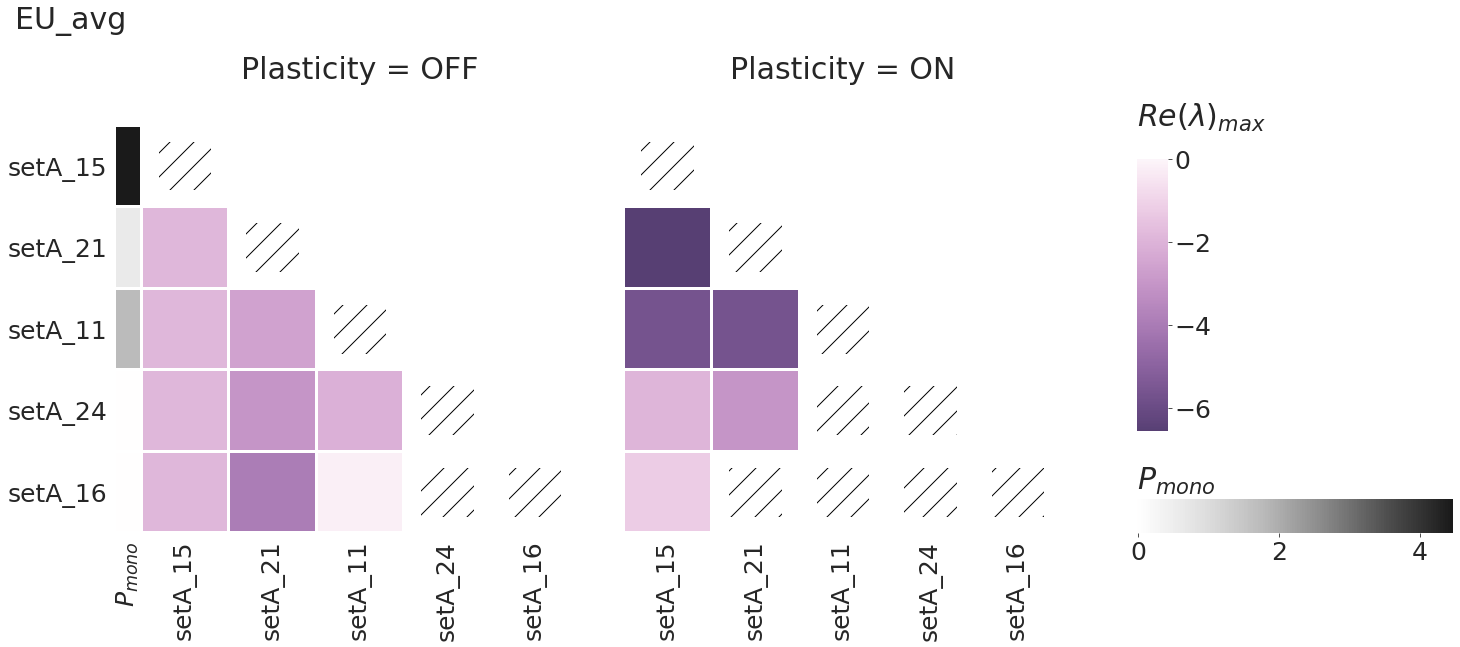

In [10]:
# EU_avg
i=0

fig = plt.figure(figsize=(24, 7.5))
fig.suptitle(media[i], x=0.1, y=1.1)

outer = gridspec.GridSpec(nrows=12, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], 
                                                 wspace=0.1, hspace=0.0, width_ratios=[0.515, 0.485])
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-3, 1], wspace=0.05, hspace=0.0)

sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

re_cbar = fig.add_subplot(inner_cbar[0])
re_cbar.set_title(r'$Re(\lambda)_{max}$', fontdict={'fontsize':30}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(outer[-1,-1])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Stability
sns.heatmap(data=sfm_stab[i, :, :], vmin=stab_min, vmax=0.0,
            xticklabels=sfm_meta['species_ID'], yticklabels=False, linewidths=2.0,
            cmap=stab_cmap, square=True, cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_stab[i, :, :], vmin=stab_min, vmax=0.0,
            xticklabels=plastic_meta['species_ID'], yticklabels=False, linewidths=2.0, 
            cmap=stab_cmap, square=True, cbar_ax=re_cbar, ax=plastic_hm)

# Annotate region of intra-species interaction & competitive exclusion
sfm_patch = [(a+0.2, b+0.2) for a in range(sfm_stab.shape[2]) for b in range(a, sfm_stab.shape[1]) if np.isnan(sfm_stab[i, b, a])]
for p in sfm_patch:
    sfm_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

plastic_patch = [(a+0.2, b+0.2) for a in range(plastic_stab.shape[2]) for b in range(a, plastic_stab.shape[1]) if np.isnan(plastic_stab[i, b, a])]
for p in plastic_patch:
    plastic_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, cbar_kws={"orientation": "horizontal"}, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

re_cbar.axis('tight')
meta_cbar.axis('tight')

plt.savefig('./fig/linear_stab.' + media[i] + '.svg', transparent=True, bbox_inches='tight')

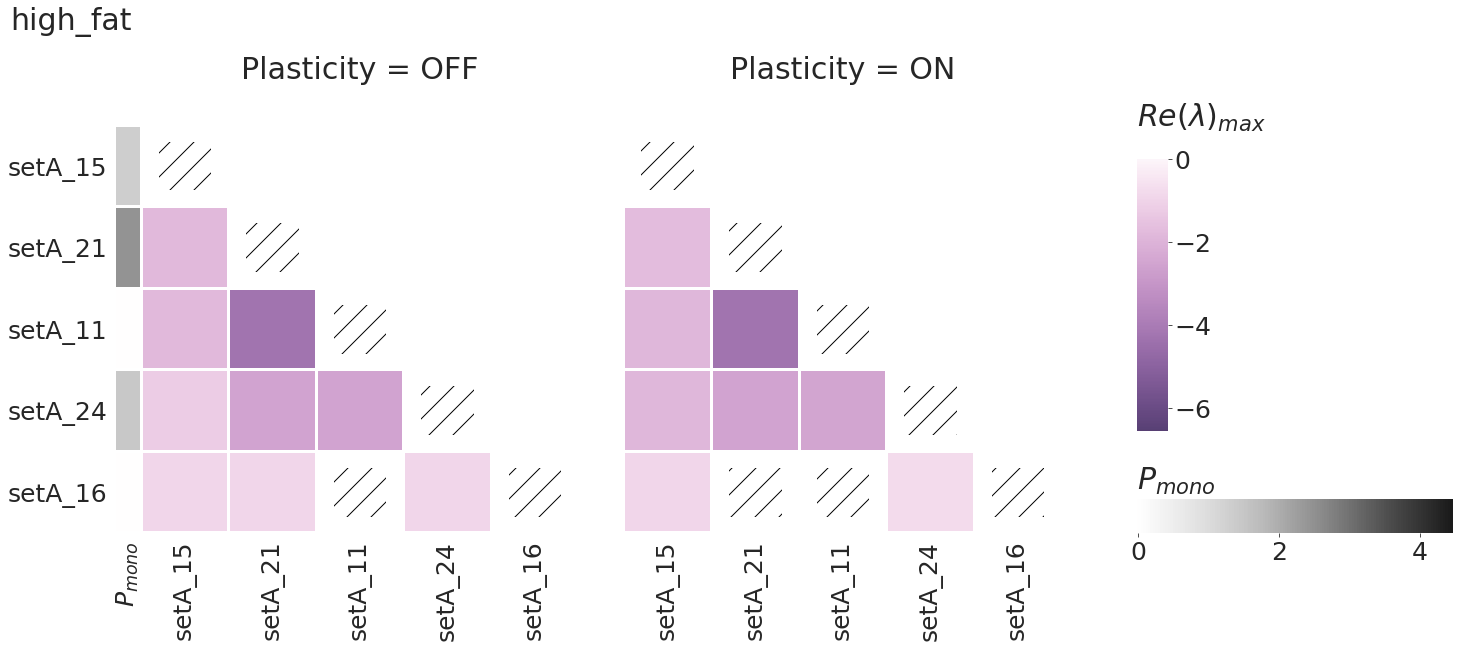

In [11]:
# high_fat
i=1

fig = plt.figure(figsize=(24, 7.5))
fig.suptitle(media[i], x=0.1, y=1.1)

outer = gridspec.GridSpec(nrows=12, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], 
                                                 wspace=0.1, hspace=0.0, width_ratios=[0.515, 0.485])
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-3, 1], wspace=0.05, hspace=0.0)

sfm_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])
species_meta = fig.add_subplot(sfm_space[0])
sfm_hm = fig.add_subplot(sfm_space[1])
sfm_hm.set_title('Plasticity = OFF', y=1.1)

plastic_hm = fig.add_subplot(inner_heatmap[1])
plastic_hm.set_title('Plasticity = ON', y=1.1)

re_cbar = fig.add_subplot(inner_cbar[0])
re_cbar.set_title(r'$Re(\lambda)_{max}$', fontdict={'fontsize':30}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(outer[-1,-1])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

# Stability
sns.heatmap(data=sfm_stab[i, :, :], vmin=stab_min, vmax=0.0,
            xticklabels=sfm_meta['species_ID'], yticklabels=False, linewidths=2.0,
            cmap=stab_cmap, square=True, cbar=False, ax=sfm_hm)

sns.heatmap(data=plastic_stab[i, :, :], vmin=stab_min, vmax=0.0,
            xticklabels=plastic_meta['species_ID'], yticklabels=False, linewidths=2.0, 
            cmap=stab_cmap, square=True, cbar_ax=re_cbar, ax=plastic_hm)

# Annotate region of intra-species interaction & competitive exclusion
sfm_patch = [(a+0.2, b+0.2) for a in range(sfm_stab.shape[2]) for b in range(a, sfm_stab.shape[1]) if np.isnan(sfm_stab[i, b, a])]
for p in sfm_patch:
    sfm_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

plastic_patch = [(a+0.2, b+0.2) for a in range(plastic_stab.shape[2]) for b in range(a, plastic_stab.shape[1]) if np.isnan(plastic_stab[i, b, a])]
for p in plastic_patch:
    plastic_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

# Species metadata
species_meta = sns.heatmap(mono_plas[[media[i]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, cbar_kws={"orientation": "horizontal"}, ax=species_meta)
species_meta.set_ylabel('')    
species_meta.set_xlabel('')
species_meta.set_xticklabels(species_meta.get_xticklabels(), rotation = 90)

species_meta.axis('tight')
sfm_hm.axis('tight')
plastic_hm.axis('tight')

re_cbar.axis('tight')
meta_cbar.axis('tight')

plt.savefig('./fig/linear_stab.' + media[i] + '.svg', transparent=True, bbox_inches='tight')

In [12]:
m=0
print(media[m])

print('\n' + 'Interaction coefficients of all 2-member communities')
print(plastic_interactions[m, :, :])
print('\n' + 'Equilibrium species densities of all 2-member communities')
print(plastic_densities[m, :, :])

i=1
j=2
print('\n' + 'Check for 2-member community: setA_21 (i=1) & setA_11 (j=2)')

ixgrid = np.ix_([i, j], [i, j])
A = plastic_interactions[m, :, :][ixgrid]
print('\n' + 'Community matrix A')
print(A)

X = plastic_densities[m, :, :][ixgrid]
print('\n' + 'Density matrix X')
print(X)

J = np.zeros(A.shape)
J[0, :] = A[0, :] * X[0, 1]
J[1, :] = A[1, :] * X[1, 0]

print('\n' + 'Jacobian matrix J')
print(J)

from scipy import linalg

eigvals = linalg.eigvals(J)
print('\n' + 'Eigenvalues of J')
print(eigvals)

max_re_eigval = np.max(eigvals.real)
print('\n' + 'Max real part of all eigenvalues of J')
print(max_re_eigval)

EU_avg

Interaction coefficients of all 2-member communities
[[-2.62694775e-02  6.40600986e-02  1.06230205e-01  2.02562400e-03  5.81236925e-02]
 [-1.60846318e-03 -6.15524530e-02  2.19208225e-08  6.11764956e-07             nan]
 [-4.43228698e-06  0.00000000e+00 -1.00843339e-01             nan             nan]
 [ 1.85672307e-07  0.00000000e+00             nan -1.36273447e-01             nan]
 [-8.00820904e-02             nan             nan             nan -2.98673306e-01]]

Equilibrium species densities of all 2-member communities
[[         nan 289.9759     298.7336      73.3946      75.32748   ]
 [ 89.51462             nan  97.09217     97.09237             nan]
 [ 56.14576     56.15889             nan          nan          nan]
 [ 22.1353      22.1352              nan          nan          nan]
 [  1.64500118          nan          nan          nan          nan]]

Check for 2-member community: setA_21 (i=1) & setA_11 (j=2)

Community matrix A
[[-6.15524530e-02  2.19208225e-08]
 [ 0.00